# Linear Sweep Search

In this file I develop an algorithm to search the carpal tunnel along one axis using a simple clustering algorithm

In [1]:
# import
import sys
sys.path.append('../')

import logging
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage import label

from visualization_utils import show_slices 
from tissue_clustering import Tissues

# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

Load the dataset

In [2]:
# Load the image data
mri_1_label = sitk.ReadImage('..\MRI\Labels\labels_00001.nii')
mri_1_label_data = sitk.GetArrayFromImage(mri_1_label)
mri_1_label_data.shape

(61, 864, 606)

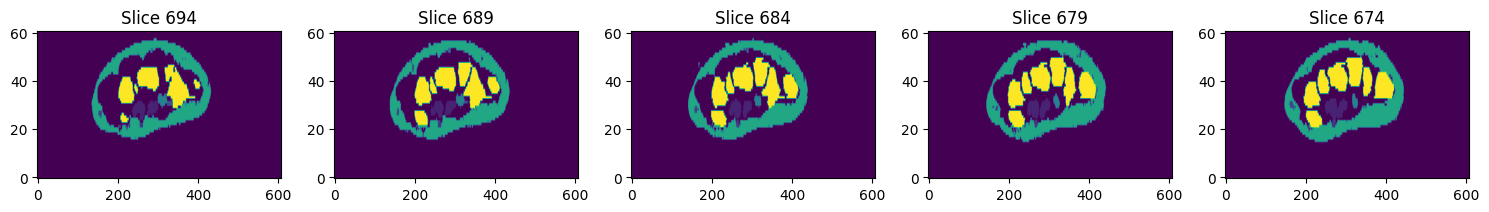

In [3]:
show_slices(mri_1_label_data,  mri_1_label_data.shape[1]-170, 5, 5)

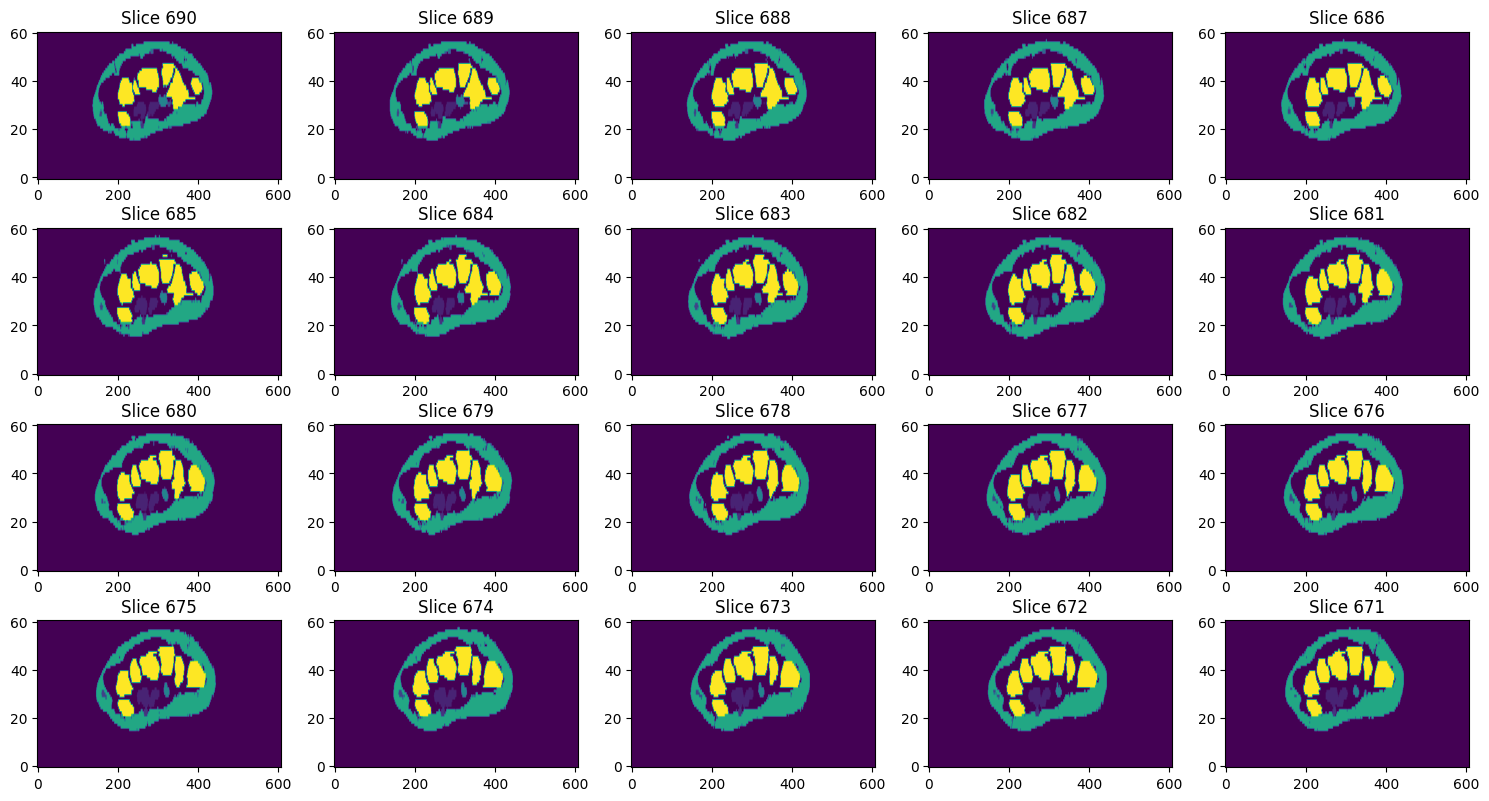

In [4]:
show_slices(data=mri_1_label_data,  start=690, end=20, lap=1)

In [5]:
np.savetxt("..\outputs\carpal_values.txt", mri_1_label_data[:, 679, :], fmt='%.3f')

In [6]:
tissues = { "bones": 20,
            "tendins": 2,
            "ulnar": 3,}

In [7]:
tissuesClass = Tissues(tissues_dict=tissues)
tissuesClass.get_tissues()

{'bones': 20, 'tendins': 2, 'ulnar': 3}

In [8]:
def find_clusters(tissue_value: int, slice: np.ndarray) -> list[dict]:
    # Create a binary mask based on the threshold
    binary_mask = (slice == tissue_value)

    # Check if there are tissues with given label
    if np.all(binary_mask == False):
        print("No tissues to cluster. Please set values using set_values method.")
        return []

    # Label connected components in the binary mask
    labeled_array, num_clusters = label(binary_mask)

    # Extract clusters and their centers
    cluster_data = []
    
    for cluster_label in range(num_clusters):
        cluster_indices = np.where(labeled_array == cluster_label+1)
        # Calculate the center of the cluster
        center_x = np.mean(cluster_indices[0])
        center_y = np.mean(cluster_indices[1])
        center = (center_x, center_y)

        # Save both the cluster and center under the same key
        cluster_data.append({'cluster': np.array(list(zip(cluster_indices[0], cluster_indices[1]))),
                             'center': center})

    return cluster_data

In [9]:
def cluster_iter(tissues: dict, slice: np.ndarray) -> dict:
    # store clsuters of tissues in a dict
    tissues_clusters = {}
    
    for tissue in tissues:
        print(f"Finding {tissue} clusters, with value {tissues[tissue]}:")
        tissues_clusters[tissue] = (find_clusters(tissues[tissue], slice))

        print(f"Found {len(tissues_clusters[tissue])} clusters\n")
    print("---------------------------------------\n")     
    return tissues_clusters

In [10]:
def show_cluster_centers(tissue_clusters: dict, slice: np.ndarray) -> None:

    for tissue in tissue_clusters:
        for label, data in enumerate(tissue_clusters[tissue]):
            # plot clusters with different colors
            plt.scatter(data['center'][1],data['center'][0], color='red', marker='*', s=20) # plot centers

    plt.imshow(slice.T, aspect=6, origin='lower')

In [11]:
def show_clusters(tissue_clusters: dict, slice: np.ndarray) -> None:
    # create an empty array for cluster labels
    cluster_labels = slice.copy()

    for tissue in tissue_clusters:
        for label, data in enumerate(tissue_clusters[tissue]):
            # plot clusters with different colors
            cluster_labels[tuple(data['cluster'].T)] = (label + 1)*10
            plt.scatter(data['center'][1],data['center'][0], color='red', marker='*', s=20) # plot centers
    plt.imshow(cluster_labels, aspect=6, origin='lower')

In [12]:
def show_only_clusters(tissue_clusters: dict, slice: np.ndarray) -> None:
    # create an empty array for cluster labels
    cluster_labels = np.ones_like(slice) * 0

    for tissue in tissue_clusters:
        for label, data in enumerate(tissue_clusters[tissue]):
            # plot clusters with different colors
            cluster_labels[tuple(data['cluster'].T)] = (label + 1)*10
            plt.scatter(data['center'][1],data['center'][0], color='red', marker='*', s=20) # plot centers

    plt.imshow(cluster_labels, aspect=6, origin='lower')

Finding bones clusters, with value 20:
Found 7 clusters

Finding tendins clusters, with value 2:
Found 2 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------



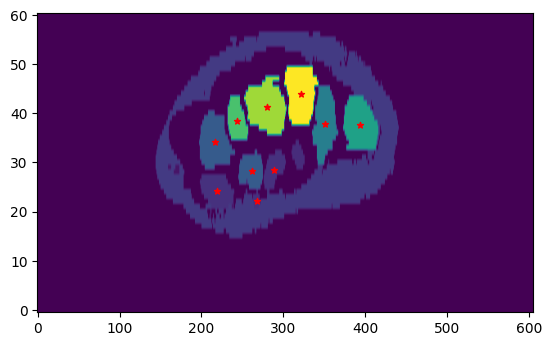

In [13]:
clusters_679 = cluster_iter(tissues, mri_1_label_data[:, 679, :])
show_clusters(clusters_679, mri_1_label_data[:, 679, :])
plt.show()

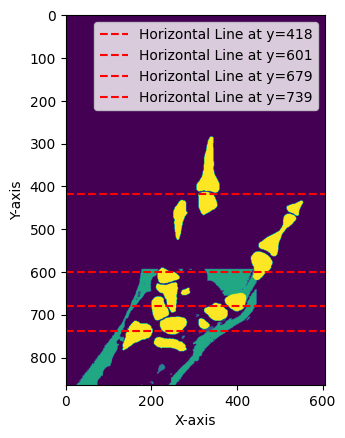

In [14]:
# Draw a horizontal line at y=n
plt.axhline(y=418, color='red', linestyle='--', label=f'Horizontal Line at y={418}')
plt.axhline(y=601, color='red', linestyle='--', label=f'Horizontal Line at y={601}')
plt.axhline(y=679, color='red', linestyle='--', label=f'Horizontal Line at y={679}')
plt.axhline(y=739, color='red', linestyle='--', label=f'Horizontal Line at y={739}')


plt.imshow(mri_1_label_data[35, :, :], label='Hand')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.show()

Finding bones clusters, with value 20:
Found 6 clusters

Finding tendins clusters, with value 2:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

Finding ulnar clusters, with value 3:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

---------------------------------------



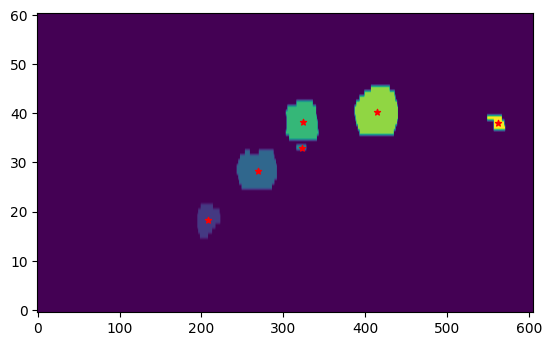

In [15]:
clusters_418 = cluster_iter(tissues, mri_1_label_data[:, 418, :])
show_clusters(clusters_418, mri_1_label_data[:, 418, :])

Finding bones clusters, with value 20:
Found 4 clusters

Finding tendins clusters, with value 2:
Found 3 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------



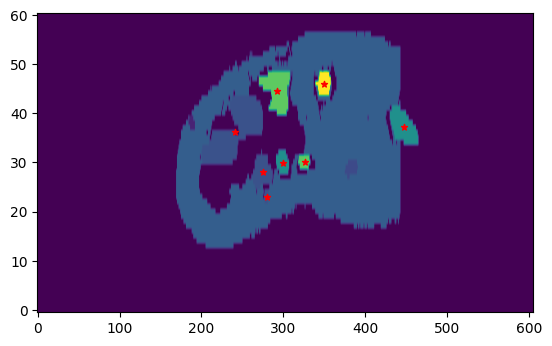

Finding bones clusters, with value 20:
Found 4 clusters

Finding tendins clusters, with value 2:
Found 3 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------



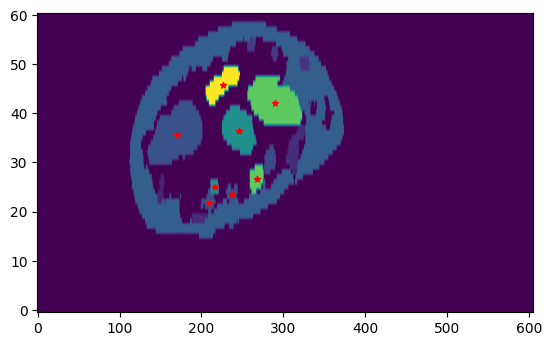

In [16]:
cluster_601 = cluster_iter(tissues, mri_1_label_data[:, 601, :])
show_clusters(cluster_601, mri_1_label_data[:, 601, :])
plt.show()
cluster_739 = cluster_iter(tissues, mri_1_label_data[:, 739, :])
show_clusters(cluster_739, mri_1_label_data[:, 739, :])
plt.show()


In [17]:
def loss_fct(tissue_clusters: dict) -> float:

    print('####################################################')
    print("Calculating loss function:")

    # Presence of landmark tissues:
    
    # Standard plane has 7 bones, 2 tendins and 1 ulnar cluster
    bones_loss = abs(len(tissue_clusters['bones']) - 7)
    ligament_loss = abs(len(tissue_clusters['tendins']) - 2)
    ulnar_loss = abs(len(tissue_clusters['ulnar']) - 1)

    landmark_loss = bones_loss + ligament_loss + ulnar_loss

    # Absence of landmarks:
    missing_landmark_loss = 0

    # Location of landmarks:
    location_loss = 1

    # There must be bones:
    if len(tissue_clusters['bones'])!=0:
        
        # Get centers of tissue clusters:
        bones_centers = [cluster['center'] for _, cluster in enumerate(tissue_clusters['bones'])]
        bones_centers_mean = np.mean(bones_centers, axis=0)

        # There must be tendins:
        if len(tissue_clusters['tendins'])!=0:

            # Get centers of tissue clusters:
            ligament_centers = [cluster['center'] for _, cluster in enumerate(tissue_clusters['tendins'])]
            ligament_centers_mean = np.mean(ligament_centers, axis=0)

            # Check the orientation of the arm:
            # The bones center might be over or undere the tendins center depending on the origin
            if bones_centers_mean[1] > ligament_centers_mean[1]:
                print("Orientation: bones over tendins")
                orientation = -1
            else: 
                print("Orientation: bones under tendins")
                orientation = 1

            # There must be one ulnar artery:
            if len(tissue_clusters['ulnar'])==1:
                
                # There must be only one ulnar tissue so there is no need to take the mean
                ulnar_center = tissue_clusters['ulnar'][0]['center']

                # Ulnar artery must be over tendins in the positive orientation:
                if orientation * ulnar_center[1] > orientation * ligament_centers_mean[1]: 
                    location_loss = 0
                else: print("Ulnar center not where excpected")
            
            # if no ulnar artery
            else: 
                missing_landmark_loss = 1
                print("No ulnar artery found")
        # if no tendins
        else: 
            missing_landmark_loss = 2
            print("No tendins found")
    # if no bones:
    else: 
        missing_landmark_loss = 3
        print("No bones found")

    # Loss is bounded between 0 and 1
    loss = (1/3)*(0.1*landmark_loss + (1/3)*missing_landmark_loss + location_loss)

    print(f"Landmark loss: {landmark_loss}")
    print(f"Missing landmark loss: {missing_landmark_loss}")
    print(f"Location loss: {location_loss}")
    print(f"Total loss: {loss}")

    print('#################################################### \n')

    return loss

In [18]:
clusters_679 = cluster_iter(tissues, mri_1_label_data[:, 679, :])

bones_centers = [cluster['center'] for _, cluster in enumerate(clusters_679['bones'])]
ligament_centers = [cluster['center'] for _, cluster in enumerate(clusters_679['tendins'])]

bones_center = np.mean(bones_centers, axis=0)
print("bones_center: ", bones_center)
ligament_center = np.mean(ligament_centers, axis=0)
print("ligament_center: ", ligament_center)
print(np.shape(clusters_679['ulnar']))
ulnar_center = clusters_679['ulnar'][0]['center']
print("ulnar_center: ", ulnar_center)

Finding bones clusters, with value 20:
Found 7 clusters

Finding tendins clusters, with value 2:
Found 2 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------

bones_center:  [ 36.7573991  289.49905363]
ligament_center:  [ 28.34735335 275.19513233]
(1,)
ulnar_center:  (22.25, 267.5833333333333)


In [19]:
loss_fct(clusters_679)

####################################################
Calculating loss function:
Orientation: bones over tendins
Landmark loss: 0
Missing landmark loss: 0
Location loss: 0
Total loss: 0.0
#################################################### 



0.0

In [20]:
sweep_loss = []

for i in range(mri_1_label_data.shape[1]):
    cluster = cluster_iter(tissues, mri_1_label_data[:, i, :])
    sweep_loss.append(loss_fct(cluster))
    print(f"Loss for slice {i}: {sweep_loss[i]}")
    

Finding bones clusters, with value 20:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

Finding tendins clusters, with value 2:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

Finding ulnar clusters, with value 3:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

---------------------------------------

####################################################
Calculating loss function:
No bones found
Landmark loss: 10
Missing landmark loss: 3
Location loss: 1
Total loss: 1.0
#################################################### 

Loss for slice 0: 1.0
Finding bones clusters, with value 20:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

Finding tendins clusters, with value 2:
No tissues to cluster. Please set values using set_values method.
Found 0 clusters

Finding ulnar clusters, with value 3:
No tissues to cluster. Please set values using set_values

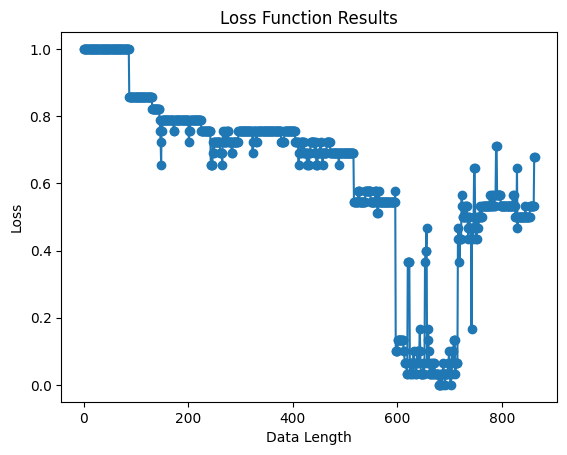

In [21]:
# Plot the loss results over the length of the data
plt.plot(range(len(sweep_loss)), sweep_loss, marker='o')

# Add labels and title
plt.xlabel('Data Length')
plt.ylabel('Loss')
plt.title('Loss Function Results')

# Show the plot
plt.show()

In [22]:
# Find indices where the loss is equal to 0
zero_loss_indices = np.where(np.array(sweep_loss) == 0)[0]
print(f"{len(zero_loss_indices)} indices return a zero loss: ", zero_loss_indices)

7 indices return a zero loss:  [679 680 681 682 685 691 702]


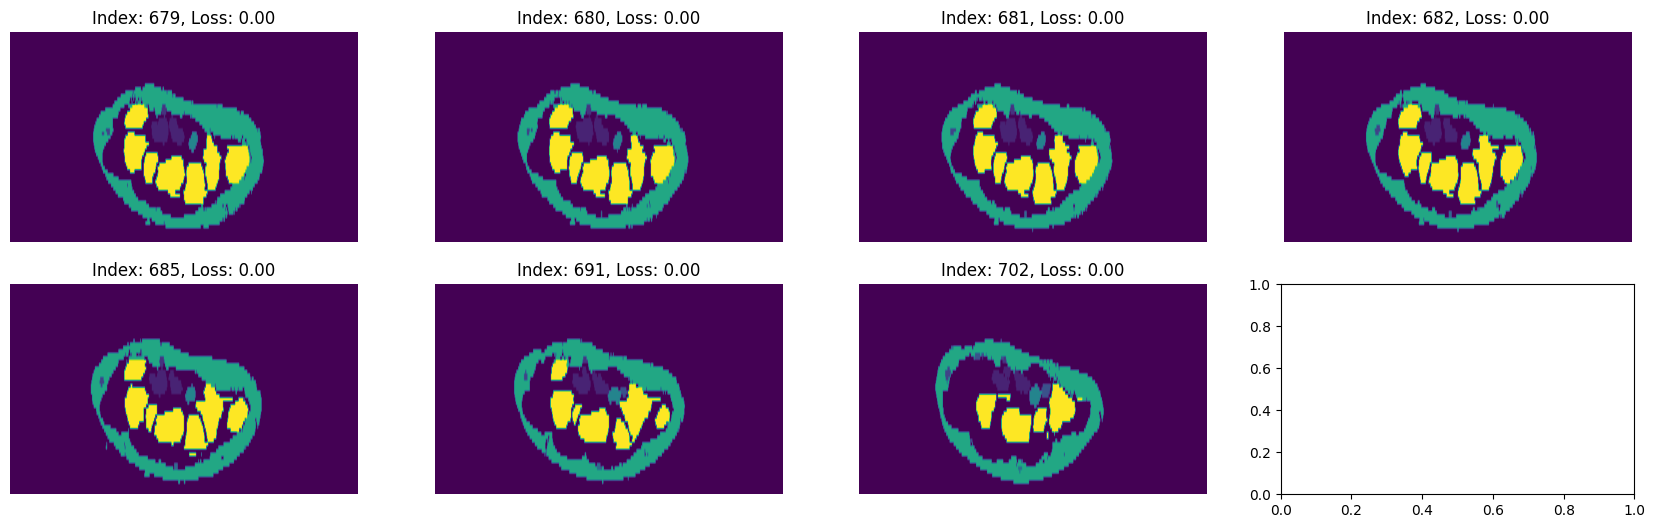

In [25]:
# Create a subplot for each image with 0 loss
fig, axes = plt.subplots(2, 4, figsize=(21, 6))

axes = axes.flatten()
for i, idx in enumerate(zero_loss_indices):
    # Plot the image
    axes[i].imshow(mri_1_label_data[:, idx, :], aspect=6)
    axes[i].set_title(f'Index: {idx}, Loss: {sweep_loss[idx]:.2f}')
    axes[i].axis('off')

plt.show()

Finding bones clusters, with value 20:
Found 7 clusters

Finding tendins clusters, with value 2:
Found 2 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------



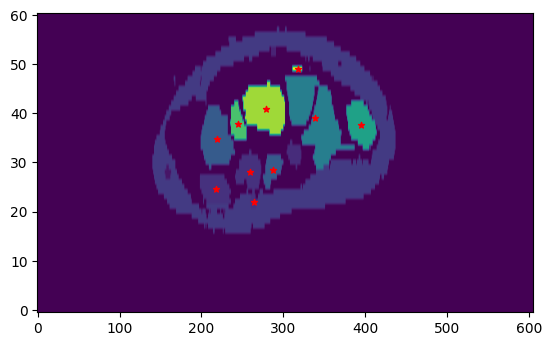

Finding bones clusters, with value 20:
Found 7 clusters

Finding tendins clusters, with value 2:
Found 2 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------



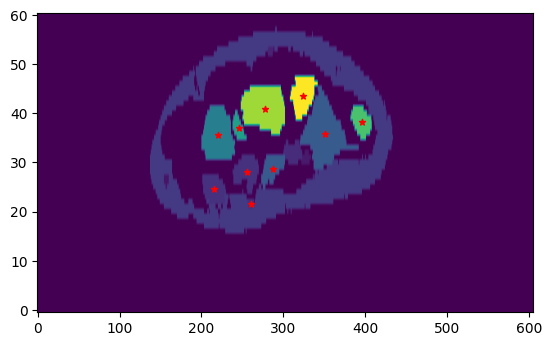

Finding bones clusters, with value 20:
Found 7 clusters

Finding tendins clusters, with value 2:
Found 2 clusters

Finding ulnar clusters, with value 3:
Found 1 clusters

---------------------------------------



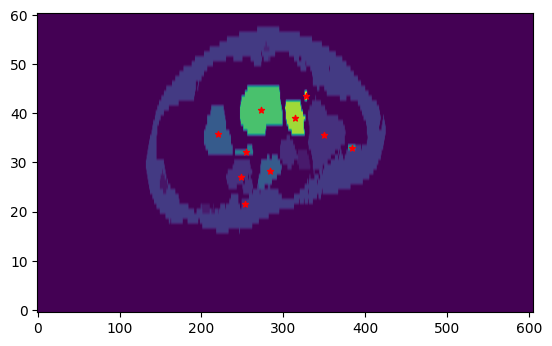

In [24]:
cluster_685 = cluster_iter(tissues, mri_1_label_data[:, 685, :])
show_clusters(cluster_685, mri_1_label_data[:, 685, :])
plt.show()

cluster_691 = cluster_iter(tissues, mri_1_label_data[:, 691, :])
show_clusters(cluster_691, mri_1_label_data[:, 691, :])
plt.show()

cluster_702 = cluster_iter(tissues, mri_1_label_data[:, 702, :])
show_clusters(cluster_702, mri_1_label_data[:, 702, :])
plt.show()

The slices from 679:682 show good results.
The slices right before or right after this optimal range are excluded because the loss function is strictly penalizing the cluster size of bones and tendins. 
In fact, 683:690 might all be accepted, but two bones clusters are too close to be distinguished.
Same problem from 670:679, where the tendins form only one cluster instead of two.

685 is an exception, since a small bones cluster is missclassified.

691 and 702 are outliers that should be excluded by refining the loss function.

Another option is to develop a better clustering technique and retest the loss function on that.